In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
#https://drive.google.com/file/d/183B_W_R2qSnT_JjEUcI3Ny1vH36desCp/view?usp=sharing
file1 = drive.CreateFile({'id':'183B_W_R2qSnT_JjEUcI3Ny1vH36desCp'}) # replace the id with id of file you want to access
file1.GetContentFile('credit_train.csv')

In [3]:
#https://drive.google.com/file/d/1ceLPls-2L2RuPoAJXAwGgcqxufoHAs0t/view?usp=sharing
file2 = drive.CreateFile({'id':'1ceLPls-2L2RuPoAJXAwGgcqxufoHAs0t'}) # replace the id with id of file you want to access
file2.GetContentFile('credit_test.csv')

Part1: Data Preprocessing

In [50]:
import pandas as pd
import numpy as np

In [51]:
df_train = pd.read_csv('credit_train.csv')

In [52]:
df_test = pd.read_csv('credit_test.csv')

In [53]:
print(df_train.shape)
print(df_test.shape)

(100514, 19)
(10353, 18)


In [54]:
df = pd.concat([df_train, df_test], join = "inner")

In [55]:
df.head()

,Loan ID,Customer ID,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [56]:
df.info()
#non numerica type columns: Loan_ID, Customer ID, Loan Status, Term, Years in Current job, Home Ownership, Purpose

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110867 entries, 0 to 10352
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       110000 non-null  object 
 1   Customer ID                   110000 non-null  object 
 2   Current Loan Amount           110000 non-null  float64
 3   Term                          110000 non-null  object 
 4   Credit Score                  88865 non-null   float64
 5   Annual Income                 88865 non-null   float64
 6   Years in current job          105351 non-null  object 
 7   Home Ownership                110000 non-null  object 
 8   Purpose                       110000 non-null  object 
 9   Monthly Debt                  110000 non-null  float64
 10  Years of Credit History       110000 non-null  float64
 11  Months since last delinquent  51553 non-null   float64
 12  Number of Open Accounts       110000 non-null

In [13]:
len(df)

110867

In [57]:
#check missing values 
df_train.isna().sum()

Loan ID                           514
Customer ID                       514
Loan Status                       514
Current Loan Amount               514
Term                              514
Credit Score                    19668
Annual Income                   19668
Years in current job             4736
Home Ownership                    514
Purpose                           514
Monthly Debt                      514
Years of Credit History           514
Months since last delinquent    53655
Number of Open Accounts           514
Number of Credit Problems         514
Current Credit Balance            514
Maximum Open Credit               516
Bankruptcies                      718
Tax Liens                         524
dtype: int64

In [58]:
print(df['Months since last delinquent'].isna().sum()/len(df))

0.5350013980715632


In [59]:
type(df['Months since last delinquent'])

pandas.core.series.Series

In [60]:
#Overall, we need to impute missing values for all the columns, since missing values for Months since last delinquent take up over 50% 
import numpy as np
from sklearn.impute import SimpleImputer

In [61]:
#impute missing values for numerical data : mean
# Select numeric columns.
numeric = df.select_dtypes('number')
# Select string and object columns.
categoric = df.select_dtypes('object')

# Fill numeric columns with mean.
df[numeric.columns] = numeric.fillna(numeric.mean())
# Fill object columns with mode.
df[categoric.columns] = categoric.fillna(categoric.agg(lambda x: x.mode().values[0]))

In [62]:
#double check missing values
df.isna().sum()

Loan ID                         0
Customer ID                     0
Current Loan Amount             0
Term                            0
Credit Score                    0
Annual Income                   0
Years in current job            0
Home Ownership                  0
Purpose                         0
Monthly Debt                    0
Years of Credit History         0
Months since last delinquent    0
Number of Open Accounts         0
Number of Credit Problems       0
Current Credit Balance          0
Maximum Open Credit             0
Bankruptcies                    0
Tax Liens                       0
dtype: int64

In [63]:
#check unique values for each column
df.nunique()
#meaningful columns often have fewer number of unique colunmns
#we need to conduct some transformation for those columns which are categorical 

Loan ID                         88354
Customer ID                     88354
Current Loan Amount             22503
Term                                2
Credit Score                      327
Annual Income                   37854
Years in current job               11
Home Ownership                      4
Purpose                            16
Monthly Debt                    69751
Years of Credit History           508
Months since last delinquent      117
Number of Open Accounts            53
Number of Credit Problems          15
Current Credit Balance          33642
Maximum Open Credit             46469
Bankruptcies                        9
Tax Liens                          14
dtype: int64

In [64]:
df[categoric.columns].nunique()

Loan ID                 88354
Customer ID             88354
Term                        2
Years in current job       11
Home Ownership              4
Purpose                    16
dtype: int64

In [65]:
#feature encoding for categorical varaibles
#label encoding: convert each value in a column to a number 
#All the categorical variables except years in current job can be handled with label encoding 
#Years in current job are required to be transformed into numerical variables
#create initial categorical dataframe
categoric_cols = list(categoric.columns)
categoric_cols.remove('Years in current job')
categoric_cols

['Loan ID', 'Customer ID', 'Term', 'Home Ownership', 'Purpose']

In [66]:
#creatin instance of labelencoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[categoric_cols] = df[categoric_cols].apply(le.fit_transform)

In [67]:
df.head()

,Loan ID,Customer ID,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,7224,52478,445412.0,1,709.000000,1.167493e+06,8 years,1,5,5214.74,17.2,34.907086,6.0,1.0,228190.0,416746.0,1.0,0.0
1,24818,15821,262328.0,1,1076.594644,1.377449e+06,10+ years,1,3,33295.98,21.1,8.000000,35.0,0.0,229976.0,850784.0,0.0,0.0
2,27403,32811,99999999.0,1,741.000000,2.231892e+06,8 years,2,3,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0
3,41293,79892,347666.0,0,721.000000,8.069490e+05,3 years,2,3,8741.90,12.0,34.907086,9.0,0.0,256329.0,386958.0,0.0,0.0
4,73291,44636,176220.0,1,1076.594644,1.377449e+06,5 years,3,3,20639.70,6.1,34.907086,15.0,0.0,253460.0,427174.0,0.0,0.0


In [68]:
#convert 'years in current job' to numerical type
## Not sure how to convert 10+ years and less than 1 year to numeric type
## So I used 0 for less than 1 year, and 10 for 10+ years
label = "Years in current job"
df[label] = df[label].replace({'< 1 year':0, '1 year': 1, '2 years': 2,
                                          '3 years':3, '4 years':4, '5 years':5, 
                                          '6 years':6, '7 years':7, '8 years':8, 
                                          '9 years': 9, '10+ years': 10})

In [69]:
df.head()

,Loan ID,Customer ID,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,7224,52478,445412.0,1,709.000000,1.167493e+06,8,1,5,5214.74,17.2,34.907086,6.0,1.0,228190.0,416746.0,1.0,0.0
1,24818,15821,262328.0,1,1076.594644,1.377449e+06,10,1,3,33295.98,21.1,8.000000,35.0,0.0,229976.0,850784.0,0.0,0.0
2,27403,32811,99999999.0,1,741.000000,2.231892e+06,8,2,3,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0
3,41293,79892,347666.0,0,721.000000,8.069490e+05,3,2,3,8741.90,12.0,34.907086,9.0,0.0,256329.0,386958.0,0.0,0.0
4,73291,44636,176220.0,1,1076.594644,1.377449e+06,5,3,3,20639.70,6.1,34.907086,15.0,0.0,253460.0,427174.0,0.0,0.0


In [27]:
#check distribution of data distribution
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [28]:
get_best_distribution(df['Current Loan Amount'])
#all p-values smaller than 0.05, not normally distributed

p value for norm = 0.0


/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:1608: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))


p value for exponweib = 0.0
p value for weibull_max = 0.0
p value for weibull_min = 0.0


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for pareto = 0.0
p value for genextreme = 0.0
Best fitting distribution: norm
Best p value: 0.0
Parameters for the best fit: (11746206.8279, 31642562.073643554)


('norm', 0.0, (11746206.8279, 31642562.073643554))

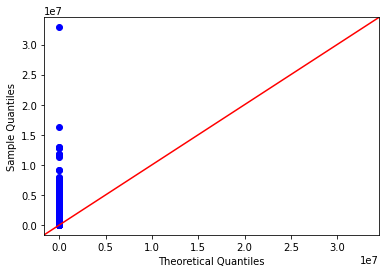

In [70]:
#use qq plot to show some distributions of variables
import statsmodels.api as sm
from scipy.stats import norm
import pylab
current_credit = df['Current Credit Balance']
sm.qqplot(current_credit, line='45')
pylab.show()
# our QQ plot shows that current loan amount has too many values at the lower end 

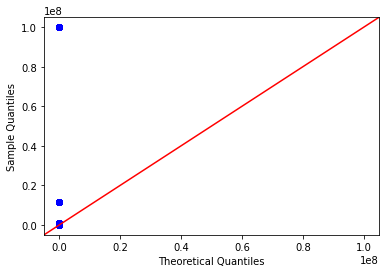

In [71]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab
current_loan = df['Current Loan Amount']
sm.qqplot(current_loan, line='45')
pylab.show()
#there are also too many lower end values for current loan amount 

In [72]:
#conduct normalization since our dataset is not normally distributed based on our observations
# normalization (x-x_min)/(x_max-x_min) ->[0,1]
#advantge of normalization: 
#1. improve training process
#2. all data are within the same scale
#3. logistic regression, SVM requires normalization
from sklearn import preprocessing
# normalize the continuous variable
numeric_vals = numeric.values#numpy array
min_max_scaler = preprocessing.MinMaxScaler()
num_scaled = min_max_scaler.fit_transform(numeric_vals)
numeric_names = list(numeric.columns)
#replace each continuous varialbe with teh normalized continuous variable
for i in range(len(numeric_names)):
  name = numeric_names[i]
  df[name].replace(num_scaled[:][i])

In [73]:
df.head()

,Loan ID,Customer ID,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,7224,52478,445412.0,1,709.000000,1.167493e+06,8,1,5,5214.74,17.2,34.907086,6.0,1.0,228190.0,416746.0,1.0,0.0
1,24818,15821,262328.0,1,1076.594644,1.377449e+06,10,1,3,33295.98,21.1,8.000000,35.0,0.0,229976.0,850784.0,0.0,0.0
2,27403,32811,99999999.0,1,741.000000,2.231892e+06,8,2,3,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0
3,41293,79892,347666.0,0,721.000000,8.069490e+05,3,2,3,8741.90,12.0,34.907086,9.0,0.0,256329.0,386958.0,0.0,0.0
4,73291,44636,176220.0,1,1076.594644,1.377449e+06,5,3,3,20639.70,6.1,34.907086,15.0,0.0,253460.0,427174.0,0.0,0.0


Part3: Training and Testing data split

In [74]:
to_drop = ["Credit Score"]
X = df.drop(to_drop, axis = 1)
y = df["Credit Score"]

In [75]:
from sklearn.model_selection import train_test_split
xtrain,xvaltest,ytrain,yvaltest = train_test_split(X,y,test_size=0.3)
xval,xtest,yval,ytest = train_test_split(xvaltest,yvaltest,test_size = 0.5)
print(xtrain.shape,xval.shape,xtest.shape)

(77606, 17) (16630, 17) (16631, 17)


Part2: Check features correlation

In [76]:
df_corr = df.drop(columns = ['Loan ID', 'Customer ID'])

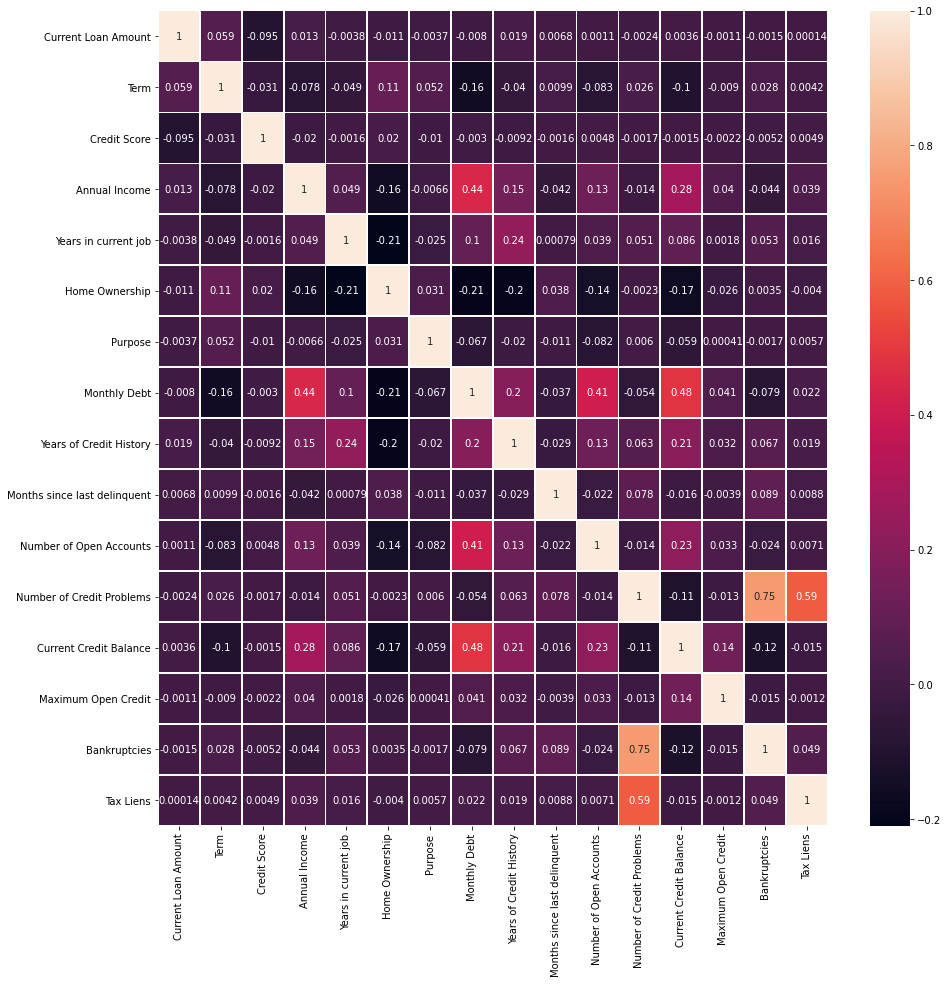

In [77]:
## Bankruptcies and Number of credit problems have relatively strong positive correlation
## Number of credit problems and Tax lien have relatively strong postiive correlation
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_corr.corr(), annot = True,linewidths=.8, ax=ax)